# Discharge Notes and Readmission Rates: Additional Features

In this notebook, I will take the merged dataset of the results of the NLP from the NLP notebook and other data features and run the models again to see if the scoring metrics improve.

TBD

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

In [2]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return round(acc_score*100,1), round(rec_score*100,1) 

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [63]:
df1 = pd.read_csv("data/admissions_nlp_processed_2.csv.gz", compression='gzip')

In [64]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      52726 non-null  object 
 1   ADMISSION_LOCATION  52726 non-null  object 
 2   DISCHARGE_LOCATION  52726 non-null  object 
 3   INSURANCE           52726 non-null  object 
 4   LANGUAGE            52726 non-null  object 
 5   RELIGION            52726 non-null  object 
 6   MARITAL_STATUS      52726 non-null  object 
 7   ETHNICITY           52726 non-null  object 
 8   DIAGNOSIS           52726 non-null  object 
 9   READMISSION         52726 non-null  int64  
 10  GENDER              52726 non-null  object 
 11  AGE                 52726 non-null  int64  
 12  CPT_CD              52726 non-null  object 
 13  DIAG_ICD9_CODE      52722 non-null  object 
 14  DRG_CODE            52726 non-null  object 
 15  PROCED_ICD9_CODE    52726 non-null  object 
 16  TEXT

In [65]:
df1.drop(['CPT_CD','DIAG_ICD9_CODE','DRG_CODE', 'DRG_CODE'], axis=1, inplace=True)

In [106]:
df1['TEXT'].head()

0    0.700572
1    0.416854
2    0.306707
3    0.362690
4    0.437668
Name: TEXT, dtype: float64

In [66]:
#set X as the text data, and y as the readmission status
X1 = df1.drop('READMISSION', axis=1)
y1 = df1['READMISSION']

In [67]:
df2 = pd.read_csv("data/admissions_nlp_processed_1.csv.gz", compression='gzip')

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  CPT_CD              52726 non-null  object
 13  DIAG_ICD9_CODE      52722 non-null  object
 14  DRG_CODE            52726 non-null  object
 15  PROCED_ICD9_CODE    52726 non-null  object
 16  TEXT                52

In [69]:
df2.drop(['CPT_CD','DIAG_ICD9_CODE','DRG_CODE', 'DRG_CODE'], axis=1, inplace=True)

In [107]:
df2['TEXT'].head()

0    1
1    0
2    0
3    0
4    0
Name: TEXT, dtype: int64

In [70]:
df2['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [71]:
#set X as the text data, and y as the readmission status
X2 = df2.drop('READMISSION', axis=1)
y2 = df2['READMISSION']

## Train, Validation, and Test Split

In [72]:
X_train1, X_v_t1, y_train1, y_v_t1 = train_test_split(X1, y1, test_size=0.30, random_state=42, stratify=y1)

In [73]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_v_t1, y_v_t1, test_size=0.50, random_state=42, stratify=y_v_t1)

In [74]:
X_train1.shape

(36908, 13)

In [75]:
X_train2, X_v_t2, y_train2, y_v_t2 = train_test_split(X2, y2, test_size=0.30, random_state=42, stratify=y2)

In [76]:
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_v_t2, y_v_t2, test_size=0.50, random_state=42, stratify=y_v_t2)

In [77]:
X_train2.shape

(36908, 13)

## Handling Imbalanced Data 

In [78]:
#concat the train dataset together
train_df = pd.concat([y_train1, X_train1], axis=1)

In [79]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [80]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [81]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [82]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [83]:
#split out the X and y of the new dataset
y_train1 = new_train_df['READMISSION']
X_train1 = new_train_df.drop('READMISSION', axis=1)
max_feats_1 = int(X_train1.shape[0]*0.10)

In [84]:
#concat the train dataset together
train_df = pd.concat([y_train2, X_train2], axis=1)

In [85]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [86]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [87]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [88]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [89]:
#split out the X and y of the new dataset
y_train2 = new_train_df['READMISSION']
X_train2 = new_train_df.drop('READMISSION', axis=1)
max_feats_2 = int(X_train2.shape[0]*0.10)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [90]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 35763 to 6932
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      4216 non-null   object 
 1   ADMISSION_LOCATION  4216 non-null   object 
 2   DISCHARGE_LOCATION  4216 non-null   object 
 3   INSURANCE           4216 non-null   object 
 4   LANGUAGE            4216 non-null   object 
 5   RELIGION            4216 non-null   object 
 6   MARITAL_STATUS      4216 non-null   object 
 7   ETHNICITY           4216 non-null   object 
 8   DIAGNOSIS           4216 non-null   object 
 9   GENDER              4216 non-null   object 
 10  AGE                 4216 non-null   int64  
 11  PROCED_ICD9_CODE    4216 non-null   object 
 12  TEXT                4216 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 461.1+ KB


In [91]:
X_num = ['AGE']
X_cat = df1.drop(['AGE', 'READMISSION', 'TEXT'], axis=1).columns

In [92]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [93]:
pca1 = PCA(n_components=max_feats_1, random_state=42)
pca2 = PCA(n_components=max_feats_2, random_state=42)

In [94]:
X_train1_scaled = c_transform.fit_transform(X_train1)
X_val1_scaled = c_transform.transform(X_val1)
X_test1_scaled = c_transform.transform(X_test1)

X_train1_pca = pca1.fit_transform(X_train1_scaled)
X_val1_pca = pca1.transform(X_val1_scaled)
X_test1_pca = pca1.transform(X_test1_scaled)

In [95]:
X_train2_scaled = c_transform.fit_transform(X_train2)
X_val2_scaled = c_transform.transform(X_val2)
X_test2_scaled = c_transform.transform(X_test2)

X_train2_pca = pca2.fit_transform(X_train2_scaled)
X_val2_pca = pca2.transform(X_val2_scaled)
X_test2_pca = pca2.transform(X_test2_scaled)

## Modeling

### Model 0: Dummy Classification

In [121]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

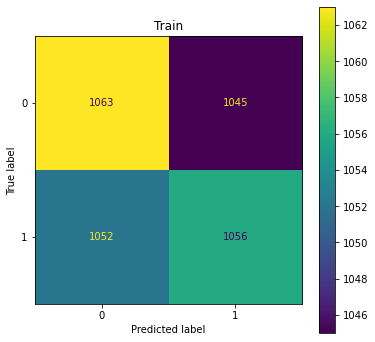

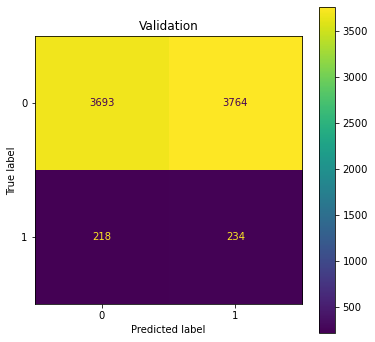

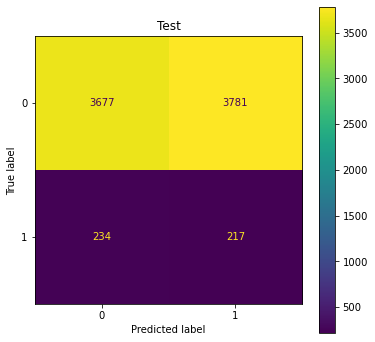

In [122]:
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
scores(pp1, X_test1, y_test1, 'Test')

In [123]:
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

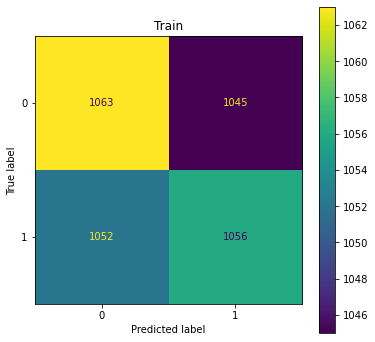

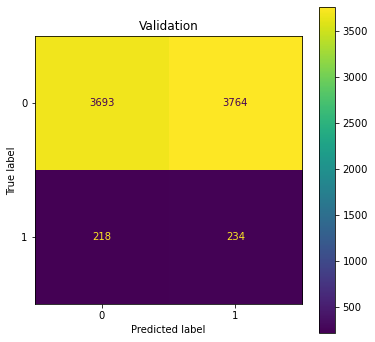

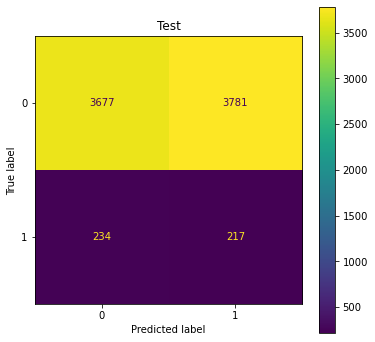

In [124]:
pp2.fit(X_train2, y_train2)

scores(pp1, X_train2, y_train2, 'Train')
scores(pp1, X_val2, y_val2, 'Validation')
scores(pp1, X_test2, y_test2, 'Test')

### Model 1: Logistic Regression

In [125]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7096774193548387
recall:    0.7556925996204934
Validation Scores
accuracy:  0.6027310658743203
recall:    0.7123893805309734
Test Scores
accuracy:  0.6190415981792894
recall:    0.6873614190687362


(61.9, 68.7)

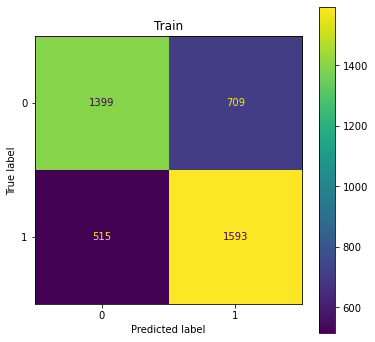

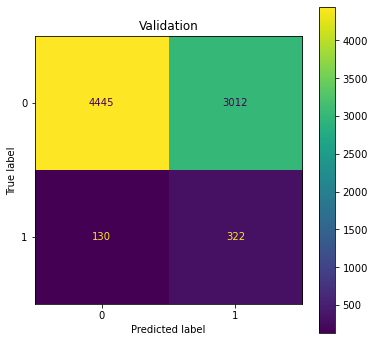

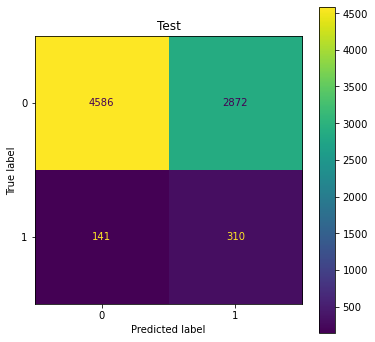

In [126]:
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
scores(pp1, X_test1, y_test1, 'Test')

In [127]:
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7096774193548387
recall:    0.7556925996204934
Validation Scores
accuracy:  0.6027310658743203
recall:    0.7123893805309734
Test Scores
accuracy:  0.6190415981792894
recall:    0.6873614190687362


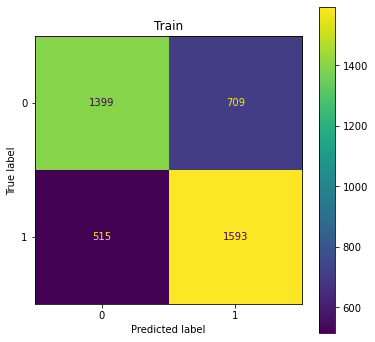

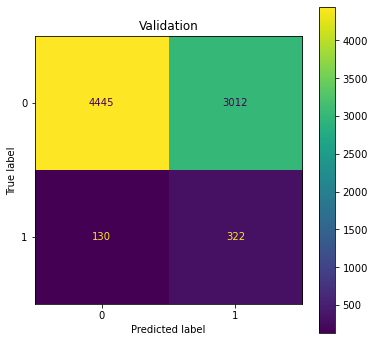

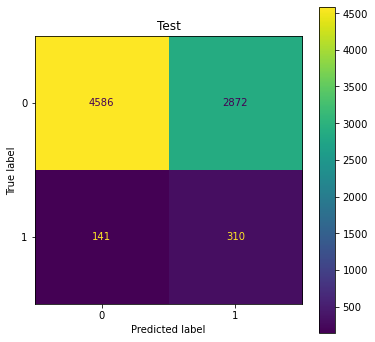

In [128]:
pp2.fit(X_train2, y_train2)

scores(pp1, X_train2, y_train2, 'Train')
scores(pp1, X_val2, y_val2, 'Validation')
log_acc, log_recall = scores(pp1, X_test2, y_test2, 'Test')

### Model 2: Random Forest

In [129]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)) 
    ])

In [130]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [132]:
gs_rf = GridSearchCV(estimator=pp1, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train Scores
accuracy:  0.6866698292220114
recall:    0.8159392789373814
Validation Scores
accuracy:  0.4475913516247313
recall:    0.8119469026548672
Test Scores
accuracy:  0.45328107219623215
recall:    0.8203991130820399


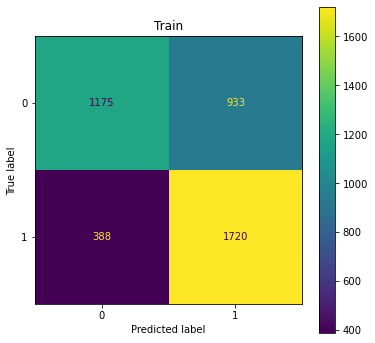

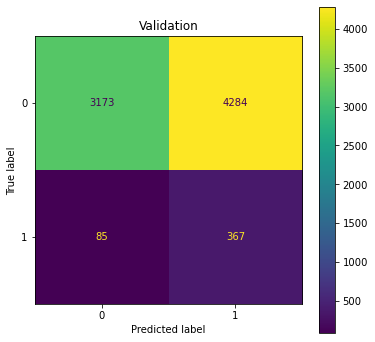

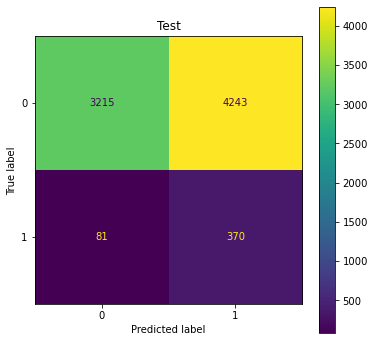

In [133]:
gs_rf.fit(X_train1, y_train1)

scores(gs_rf, X_train1, y_train1, 'Train')
scores(gs_rf, X_val1, y_val1, 'Validation')
rf_acc, rf_recall = scores(gs_rf, X_test1, y_test1, 'Test')

In [63]:
gs_rf.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2}

In [64]:
"""
{'rf__max_depth': 8,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5}
"""

"\n{'rf__max_depth': 8,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 2,\n 'rf__min_samples_split': 5}\n"

### Model 4: K-Nearest Neighbors

In [134]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('knn', KNeighborsClassifier())  
    ])

In [135]:
grid = {'knn__n_neighbors': list(range(3, 10, 2)),
        'knn__weights': ['uniform', 'distance']}

In [136]:
gs_knn = GridSearchCV(estimator=pp1, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Train Scores
accuracy:  0.9985768500948766
recall:    0.9985768500948766
Validation Scores
accuracy:  0.5670754836262486
recall:    0.6261061946902655
Test Scores
accuracy:  0.5757997218358831
recall:    0.6097560975609756


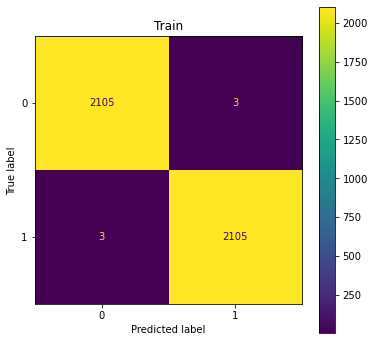

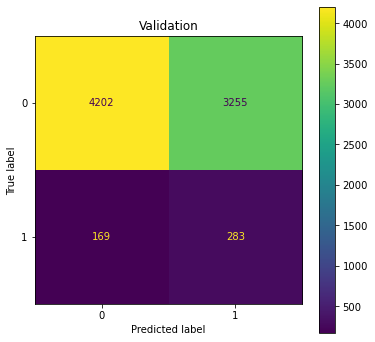

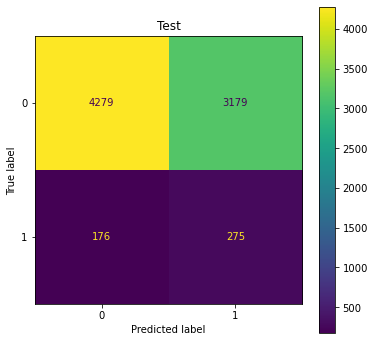

In [137]:
gs_knn.fit(X_train1, y_train1)

scores(gs_knn, X_train1, y_train1, 'Train')
scores(gs_knn, X_val1, y_val1, 'Validation')
knn_acc, knn_recall = scores(gs_knn, X_test1, y_test1, 'Test')

In [138]:
gs_knn.best_params_

{'knn__n_neighbors': 9, 'knn__weights': 'distance'}

In [139]:
"""
{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}\n"

### Model 5: Decision Tree Model

In [140]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  
    ])

In [141]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,16, 5),
        'dt__min_samples_split': np.arange(40, 101, 20),
        'dt__min_samples_leaf': np.arange(40, 101,20)
       }

In [142]:
gs_dt = GridSearchCV(estimator=pp1, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

In [ ]:
gs_dt.fit(X_train1, y_train1)

scores(gs_dt, X_train1, y_train1, 'Train')
scores(gs_dt, X_val1, y_val1, 'Validation')
dt_acc, dt_recall = scores(gs_dt, X_test1, y_test1, 'Test')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [ ]:
gs_dt.best_params_

In [76]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 40,
 'dt__min_samples_split': 100
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 6,\n 'dt__min_samples_leaf': 40,\n 'dt__min_samples_split': 100\n"

### Model 6: Gradient Boost

In [ ]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))  
    ])

In [ ]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[10, 50, 100, 1000],
        'gbc__max_depth':[3, 5, 10, 20]
       }

In [ ]:
gs_gbc = GridSearchCV(estimator=pp1, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

In [ ]:
gs_gbc.fit(X_train1, y_train1)

scores(gs_gbc, X_train1, y_train1, 'Train')
scores(gs_gbc, X_val1, y_val1, 'Validation')
gbc_acc, gbc_recall = scores(gs_gbc, X_test1, y_test1, 'Test')

In [ ]:
gs_gbc.best_params_

In [82]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 3,\n 'gbc__max_features': 'auto',\n 'gbc__min_samples_split': 1000\n"